## Predictive Modeling (IS2) - No Strength of Schedule Adjustment

This is a version specifically for the Subtraction Analysis where there is no Strength of Schedule Adjustment. We are only using Gradient Boosting Regression model here, as it was already identified as the best model (with SOS-adjusted features intact). However, hyperparameter optimization is acarried out anew here for that model due to the stripping out of SOS-adjustment that affects multiple features. 

### Summary of Previous Stage (see Notebook 3; IS2_Preprocessing_Training)

Note that puzzles solved in 2018 and 2019 have been removed during the feature generation stage due to the volatility of times in that solve period. Features (IS2 'past performance' class) with accrual, however, still accrued from that period prior to its removal.  

#### 2 Linear Regression "Benchmark" models were generated to predict GMS solve times on 15x15 (Mon-Sat) puzzles:
* 1) A "dummy" model, which simply uses mean of training data split to predict target feature -GMS's raw solve time (in min)
    * Root Mean Squared Error (RMSE) Training Set: 13.0;  Test Set: 17.0  
* 3) A univariate linear model using IS2's puzzle-day specific mean solve time across the entire sample as the sole predictive feature (ie, if predicting a Mon IS2 solve time, IS2 Mon mean across the entire sample is used to predict)
    * Root Mean Squared Error (RMSE) Training Set: 9.45(.64); Test Set: 13.1 
 
80%/20% Train/Test split was used for each of these models due to data scarcity 


### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
#from library.sb_utils import save_file

### Load and Filter Data

Filtering parameters identical to in dummy/simple modeling stage. 

In [2]:
# Load data
# 2018 and 2019 solves already filtered out
df = pd.read_csv('../data/df_for_modeling_no_SOS_adj.csv')
df.head()

,P_Date,P_Date_str,IS2_Completed,Comp_Date,Comp_Date_str,Comp_Hr,Solve_day_phase,IS_per_sdp_avg_past_diff_from_RPB,DOW,DOW_num,...,Circle_Count,Shade_Count,Unusual_Sym,Black_Square_Fill,Outside_Grid,Unchecked_Sq,Uniclue,Duplicate_Answers,Quantum,Wordplay
0,2022-05-31 00:00:00,2022-05-31,1.0,2024-02-25 14:42:15,2024-02-25,14,3.0,-13.15,Tuesday,3.0,...,0,0,0,0,0,0,0,0,0,4.0
1,2022-05-30 00:00:00,2022-05-30,1.0,2024-02-25 14:32:11,2024-02-25,14,3.0,-13.10,Monday,2.0,...,0,0,0,0,0,0,0,0,0,3.0
2,2022-05-29 00:00:00,2022-05-29,1.0,2024-02-25 13:40:36,2024-02-25,13,3.0,-13.20,Sunday,1.0,...,0,0,1,0,0,1,0,0,0,5.0
3,2024-02-25 00:00:00,2024-02-25,1.0,2024-02-25 10:03:32,2024-02-25,10,2.0,-9.76,Sunday,1.0,...,0,0,0,0,0,0,0,0,0,12.0
4,2021-11-25 00:00:00,2021-11-25,1.0,2024-02-24 23:11:23,2024-02-24,23,4.0,-6.87,Thursday,5.0,...,0,0,0,0,0,0,0,0,0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 50 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   P_Date                                1108 non-null   object 
 1   P_Date_str                            1108 non-null   object 
 2   IS2_Completed                         1108 non-null   float64
 3   Comp_Date                             1108 non-null   object 
 4   Comp_Date_str                         1108 non-null   object 
 5   Comp_Hr                               1108 non-null   int64  
 6   Solve_day_phase                       1108 non-null   float64
 7   IS_per_sdp_avg_past_diff_from_RPB     1108 non-null   float64
 8   DOW                                   1108 non-null   object 
 9   DOW_num                               1108 non-null   float64
 10  GMST(m)                               1108 non-null   float64
 11  IS2_ST(m)        

In [4]:
# Drop some columns that we don't want/need for modeling (and a few would cause subtle forms of data leakage)
df_filter = df.copy()
df_filter.drop(['P_Date','P_Date_str', 'Comp_Date', 'Comp_Date_str', 'IS2_Completed','DOW', 'IS_pds_l10_ndw', 'GMST(m)', 'Constructors','overall_day_mean_IST(m)','Uniclue','Duplicate_Answers','Unchecked_Sq','Quantum'],inplace=True,axis=1)

In [5]:
# This one has no impact on prediction quality but was raising warning in the Linear Modeling for some reason (probably all zeroes in the training set)
df_filter.drop(['Outside_Grid'], inplace=True, axis=1)
#df_filter.drop(['Duplicate_Clues', 'Circle_Count', 'Shade_Count', 'Unusual_Sym', 'Black_Square_Fill'], inplace=True, axis=1)

In [6]:
# Making sure there's nothing still in there that would constitute data leakage
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Comp_Hr                               1108 non-null   int64  
 1   Solve_day_phase                       1108 non-null   float64
 2   IS_per_sdp_avg_past_diff_from_RPB     1108 non-null   float64
 3   DOW_num                               1108 non-null   float64
 4   IS2_ST(m)                             1108 non-null   float64
 5   IS_pds_l10_stdev                      1108 non-null   float64
 6   IS_pds_l10_ndw_no_SOS_adj             1108 non-null   float64
 7   IS_per_constr_avg_past_diff_from_RPB  619 non-null    float64
 8   IS2_pds_prior_solves_ct               1108 non-null   float64
 9   IS2_npds_prior_solves_ct              1108 non-null   float64
 10  IS2_solves_l7                         1108 non-null   float64
 11  Words            

In [7]:
#Move target feature to the front
col = df_filter.pop('IS2_ST(m)')
df_filter.insert(0, col.name, col)

In [8]:
#Filter out Sunday
df_filter =df_filter[df_filter["DOW_num"]!=1]

In [9]:
#Found a bad value in first modeling iteration, so correcting here
# df["Duplicate_Answers"].unique()
# df["Uniclue"].unique()
# df["Unchecked_Sq"].unique()
# df["Quantum"].unique()

In [9]:
#Deep copy of this df_filter that is now pared down to just the predictive features and the target feature itself 
# All features are derived from data available prior to any given puzzle being predicted on. No data leakage!
df_model1 = df_filter.copy()

In [10]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956 entries, 0 to 1107
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   IS2_ST(m)                             956 non-null    float64
 1   Comp_Hr                               956 non-null    int64  
 2   Solve_day_phase                       956 non-null    float64
 3   IS_per_sdp_avg_past_diff_from_RPB     956 non-null    float64
 4   DOW_num                               956 non-null    float64
 5   IS_pds_l10_stdev                      956 non-null    float64
 6   IS_pds_l10_ndw_no_SOS_adj             956 non-null    float64
 7   IS_per_constr_avg_past_diff_from_RPB  532 non-null    float64
 8   IS2_pds_prior_solves_ct               956 non-null    float64
 9   IS2_npds_prior_solves_ct              956 non-null    float64
 10  IS2_solves_l7                         956 non-null    float64
 11  Words             

In [11]:
df_model1.to_csv('../data/df_model1.csv', index=False)

### Data Split for Modeling

Identical split as for dummy/simple modeling

In [11]:
len(df_model1) * .80, len(df_model1) * .20

(764.8000000000001, 191.20000000000002)

In [12]:
#Replicates EXACT train-test split from dummy and simpler modeling, including random state (importantly)
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='IS2_ST(m)'), 
                                                    df_model1['IS2_ST(m)'], test_size=0.20, 
                                                    random_state=47)

In [13]:
y_train.shape, y_test.shape

((764,), (192,))

In [14]:
y_train

888     12.016667
337     14.350000
140     10.200000
39      14.633333
274      9.500000
          ...    
682     18.283333
307     23.583333
379     21.000000
1045    16.533333
157     47.733333
Name: IS2_ST(m), Length: 764, dtype: float64

In [15]:
X_train.shape, X_test.shape

((764, 34), (192, 34))

In [16]:
#Target feature (GMST(m)) training set mean
train_mean = y_train.mean()
train_mean

18.116513961605584

## Linear Model

In [18]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [19]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [20]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean','median'],
    'selectkbest__k': k
}

In [21]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [22]:
#Conduct grid search. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002EABE72A8B0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [23]:
#Best params from grid search
lr_grid_cv.best_params_

{'selectkbest__k': 8,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

### K Best Features Visualization

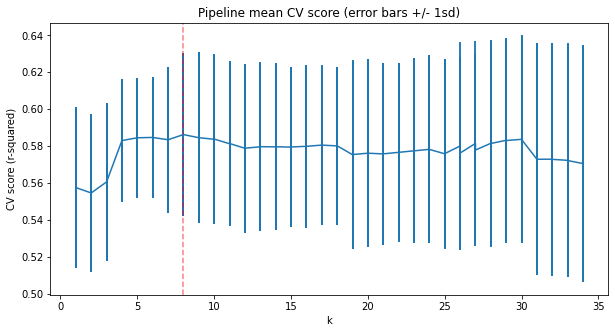

In [24]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Best Linear Model Performance Metrics

#### R-squared (COD)

In [25]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.55470233, 0.64374169, 0.52993512, 0.6312245 , 0.57186789])

In [26]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.5862943071846783, 0.04404873640719767)

#### Mean Absolute Error (MAE)

In [27]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [28]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(5.4529522800429975, 0.4937755582951299)

In [29]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

7.155254742738663

#### Mean Squared Error (MSE)

In [30]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [31]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(68.6274195880096, 5.321473939215734)

In [32]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

151.06799212845212

#### Root Mean Square Error (RMSE)

In [33]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [34]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(8.277855015376112, 0.32332017014433884)

In [35]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

12.290971976554665

### Best Linear Model Feature Importance

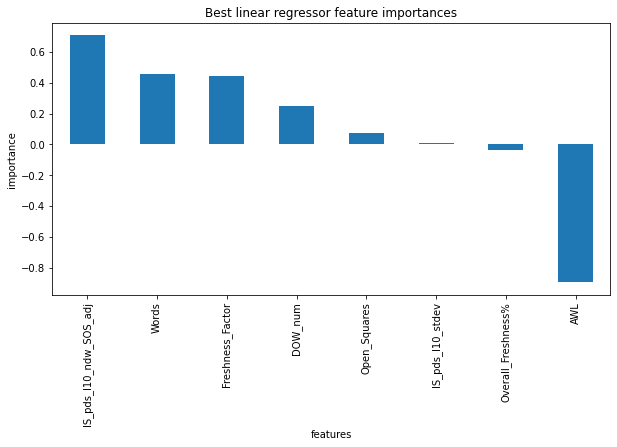

In [36]:
#Plot a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best linear regressor feature importances');

In [37]:
# Export out features and feature importances for full documentation csv
X_train.columns
lr_feat_imps.to_csv('../data/linear_feat_imps.csv', index=True)

## Random Forest Regression Model

### Random Forest Model: Hyperparameter Grid Search

In [137]:
#Define pipeline
RF_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [138]:
#Dict of available parameters for RF pipe
RF_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'randomforestregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomf

In [139]:
#Define search grid parameters

#n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
n_est = [550]

grid_params = {
        'randomforestregressor__n_estimators': n_est, 
        'randomforestregressor__max_features': [9],
        'randomforestregressor__max_depth': [11],
        'randomforestregressor__min_samples_split': [2],
        'randomforestregressor__min_samples_leaf': [4],
        'standardscaler': [None],
        'simpleimputer__strategy': ['mean']}
grid_params

{'randomforestregressor__n_estimators': [550],
 'randomforestregressor__max_features': [9],
 'randomforestregressor__max_depth': [11],
 'randomforestregressor__min_samples_split': [2],
 'randomforestregressor__min_samples_leaf': [3, 4],
 'standardscaler': [None],
 'simpleimputer__strategy': ['mean', 'median']}

In [140]:
#First Pass
# {'randomforestregressor__n_estimators': [500, 600, 700], 600
#  'randomforestregressor__max_features': [6, 8, 10], 8
#  'randomforestregressor__max_depth': [8, 10, 12], 12
#  'randomforestregressor__min_samples_split': [2, 4, 6], 2
#  'randomforestregressor__min_samples_leaf': [8, 10], 8
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['mean','median']} mean

# Second Pass
# {'randomforestregressor__n_estimators': [550, 600, 650], 550
#  'randomforestregressor__max_features': [7, 8, 9], 9
#  'randomforestregressor__max_depth': [11, 12, 13], 11 
#  'randomforestregressor__min_samples_split': [2],
#  'randomforestregressor__min_samples_leaf': [6, 7, 8], 6 (4 was best in 3,4,5,6 on third/fourth passes)
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['mean']}

In [141]:
#Call `GridSearchCV` with random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5)

In [142]:
#Conduct grid search.  
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             param_grid={'randomforestregressor__max_depth': [11],
                         'randomforestregressor__max_features': [9],
                         'randomforestregressor__min_samples_leaf': [3, 4],
                         'randomforestregressor__min_samples_split': [2],
                         'randomforestregressor__n_estimators': [550],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [None]})

In [143]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__max_depth': 11,
 'randomforestregressor__max_features': 9,
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 550,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

### Best Random Forest Model Performance Metrics

#### R-squared (COD)

In [144]:
#Cross-validation defaults to R^2 metric for scoring regression
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.58891049, 0.6348955 , 0.57090501, 0.63620457, 0.60361342])

In [145]:
#Training set CV mean and std
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.6069057990427172, 0.025583467078035417)

#### Mean Absolute Error (MAE)

In [146]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5)

In [147]:
#Training set CV mean and std
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(5.302108544786179, 0.3994968231216333)

In [148]:
# Test set mean
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

7.095551083289273

#### Mean Squared Error (MSE)

In [149]:
rf_neg_mse = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [150]:
#Training set CV mean and std
rf_mse_mean = np.mean(-1 * rf_neg_mse['test_score'])
rf_mse_std = np.std(-1 * rf_neg_mse['test_score'])
rf_mse_mean, rf_mse_std

(65.51828877554601, 5.751458528073357)

In [151]:
# Test set mean
mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

152.93328827839346

#### Root Mean Square Error (RMSE)

In [152]:
rf_neg_rmse = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [153]:
#Training set CV mean and std
rf_rmse_mean = np.mean(-1 * rf_neg_rmse['test_score'])
rf_rmse_std = np.std(-1 * rf_neg_rmse['test_score'])
rf_rmse_mean, rf_rmse_std

(8.086102626398825, 0.3650110832454833)

In [154]:
# Test set mean
np.sqrt(mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test)))

12.366619921320193

### Best Random Forest Model Feature Performance

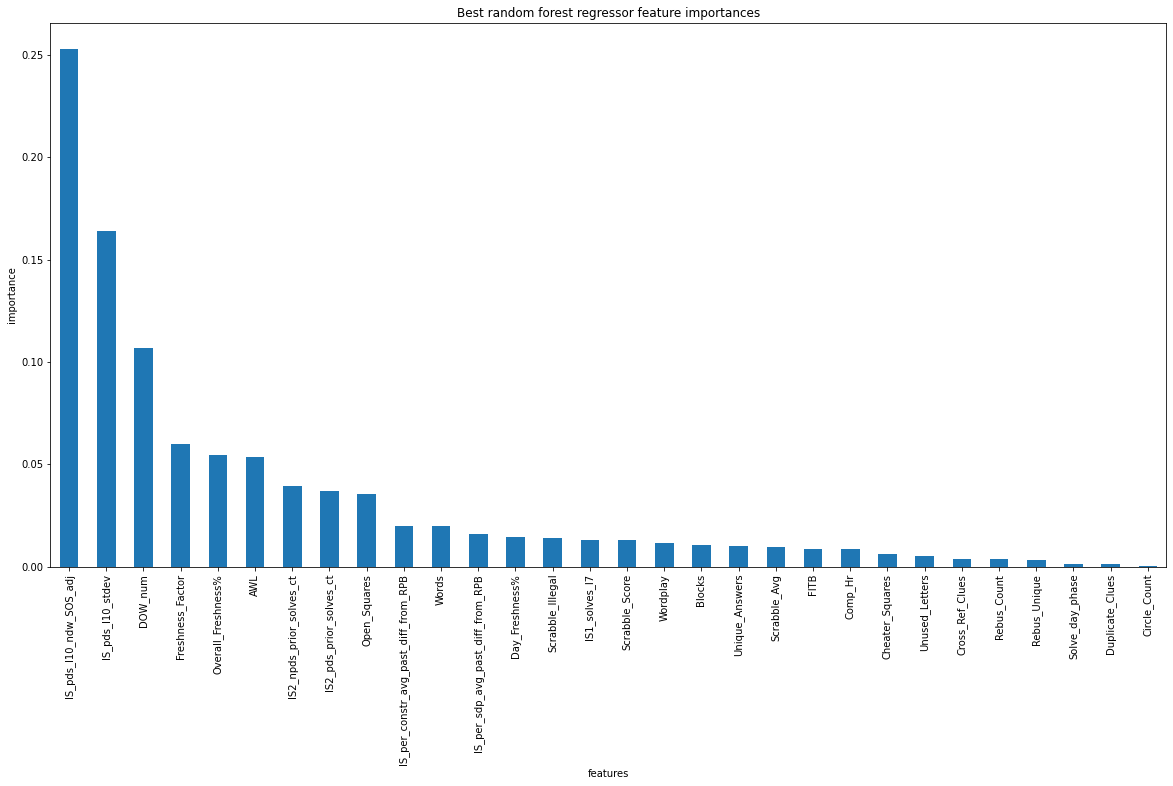

In [155]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.nlargest(30).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

#rf_gridsearch.best_estimator_.named_steps["step_name"].feature_importances_
#rf_gridsearch.best_estimator_.feature_importances_

#feat_importances = pd.Series(rf_grid_cv.feature_importances_, index=rf_grid_cv.columns)
#feat_importances.nlargest(50).plot(kind='barh')

Random Forest Regressor RMSE Train(STD)/Test for different explored hyperparameter values (summarized below each)
(8.086102626398825, 0.3650110832454833), 12.366619921320193
{'randomforestregressor__max_depth': 11,
 'randomforestregressor__max_features': 9,
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 550,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

Note on speed of RF: it could take around 1000 seconds to fit an RF with around 4M samples with the dimensions 'n_estimators': 50, 'max_depth': 200, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_jobs': 20 but only 50s for 'n_estimators': 50, 'max_depth': 200, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_jobs': 20 for similar accuracy."

## Gradient Boosting Regression Model

### Gradient Boosting Model: Hyperparameter Grid Search

In [17]:
#Define pipeline 
GB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    GradientBoostingRegressor(random_state= 47)
)

In [18]:
GB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'gradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estim

In [23]:
#Define Grid Parameters
n_est = [115,120,125] 
learning_rate = [.03] 
max_depth = [5,6,7] 
max_features = [8]
subsamples = [0.4,0.5]

grid_params = {
        'gradientboostingregressor__n_estimators': n_est,
        'standardscaler': [None],
        'simpleimputer__strategy': ['mean'],
        'gradientboostingregressor__learning_rate': learning_rate,
        'gradientboostingregressor__max_depth': max_depth,
        'gradientboostingregressor__max_features': max_features,
        'gradientboostingregressor__subsample': subsamples
}
grid_params

#Generally speaking, the four hyperparameters with the biggest impact on this model's performance are the number of models in the ensemble (n_est),
#the learning rate, the depth of the decision tree (max_depth), and the variance of the model controlled via the size of the data sample used to train 
#each model or features used in tree splits

{'gradientboostingregressor__n_estimators': [115, 120, 125],
 'standardscaler': [None],
 'simpleimputer__strategy': ['mean'],
 'gradientboostingregressor__learning_rate': [0.03],
 'gradientboostingregressor__max_depth': [5, 6, 7],
 'gradientboostingregressor__max_features': [8],
 'gradientboostingregressor__subsample': [0.4, 0.5]}

In [24]:
#First Pass (best from the run is placed outside bracket per hyperparameter)
# {'gradientboostingregressor__n_estimators': [125, 130, 135], 125
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['mean', 'median'], mean
#  'gradientboostingregressor__learning_rate': [0.02, 0.03, 0.04], .03
#  'gradientboostingregressor__max_depth': [3, 4, 5], 5
#  'gradientboostingregressor__max_features': [7, 8, 9], 8
#  'gradientboostingregressor__subsample': [0.5, 0.6, 0.7]} .5

In [25]:
#Call `GridSearchCV` with the gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
gb_grid_cv = GridSearchCV(GB_pipe, param_grid=grid_params, cv=5)

In [26]:
#conduct the grid search. 
gb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=47))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.03],
                         'gradientboostingregressor__max_depth': [5, 6, 7],
                         'gradientboostingregressor__max_features': [8],
                         'gradientboostingregressor__n_estimators': [115, 120,
                                                                     125],
                         'gradientboostingregressor__subsample': [0.4, 0.5],
                         'simpleimputer__strategy': ['mean'],
                         'standardscaler': [None]})

In [27]:
#Best params (`best_params_` attribute) from the grid search
gb_grid_cv.best_params_

{'gradientboostingregressor__learning_rate': 0.03,
 'gradientboostingregressor__max_depth': 5,
 'gradientboostingregressor__max_features': 8,
 'gradientboostingregressor__n_estimators': 120,
 'gradientboostingregressor__subsample': 0.5,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

### Best Gradient Boosting Model Performance Metrics

#### R-squared (COD)

In [28]:
#Cross-validation defaults to R^2 metric for scoring regression
gb_best_cv_results = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, cv=5)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

array([0.59127086, 0.64627206, 0.56365807, 0.65364621, 0.607311  ])

In [29]:
#Training set CV mean and std
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.6124316396898661, 0.03375403725052038)

#### Mean Absolute Error (MAE)

In [30]:
gb_neg_mae = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [31]:
#Training set CV mean and std
gb_mae_mean = np.mean(-1 * gb_neg_mae['test_score'])
gb_mae_std = np.std(-1 * gb_neg_mae['test_score'])
gb_mae_mean, gb_mae_std

(5.34841485411616, 0.4039114714883163)

In [32]:
# Test set mean
mean_absolute_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

7.254421671174323

#### Mean Squared Error (MSE)

In [33]:
gb_neg_mse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [34]:
#Training set CV mean and std
gb_mse_mean = np.mean(-1 * gb_neg_mse['test_score'])
gb_mse_std = np.std(-1 * gb_neg_mse['test_score'])
gb_mse_mean, gb_mse_std

(64.4127407540848, 4.840737856819683)

In [35]:
# Test set mean
mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

156.19663512835396

#### Root Mean Square Error (RMSE)

In [36]:
gb_neg_rmse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [37]:
#Training set CV mean and std
gb_rmse_mean = np.mean(-1 * gb_neg_rmse['test_score'])
gb_rmse_std = np.std(-1 * gb_neg_rmse['test_score'])
gb_rmse_mean, gb_rmse_std

(8.019882073111452, 0.30697277968957937)

In [38]:
# Test set mean
np.sqrt(mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test)))

12.497865222843219

### Best Gradient Boosting Model Feature Performance

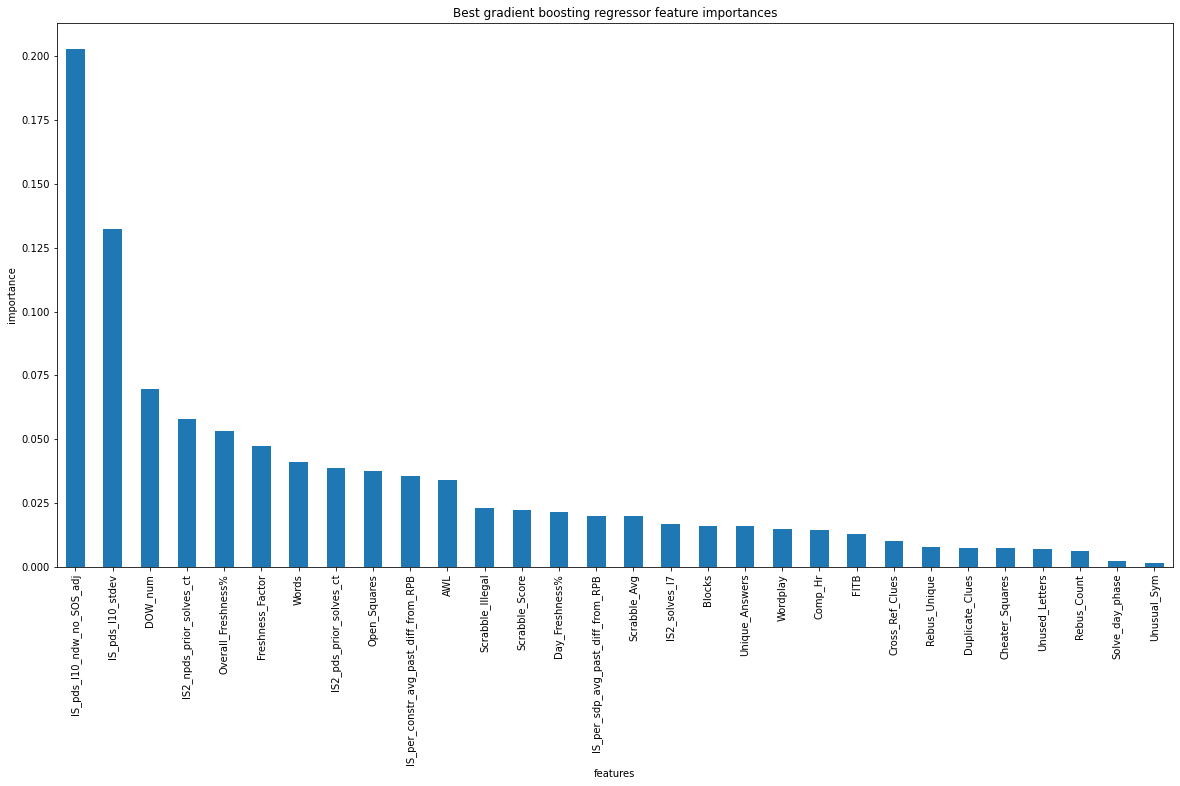

In [39]:
#Plot a barplot of the gradient boosting model's feature importances,
#assigning the `feature_importances_` attribute of 
#`gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor.feature_importances_
gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
gb_feat_imps.nlargest(30).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting regressor feature importances');

In [68]:
# Export out features and feature importances for full documentation csv
X_train.columns
gb_feat_imps.to_csv('../data/gb_feat_imps.csv', index=True)

Best GBM Model RMSE Train/Test and Best Hyperparameters

(8.02309533080152, 0.4359553959442986), 12.282071506546062
{'gradientboostingregressor__learning_rate': 0.03,
 'gradientboostingregressor__max_depth': 5,
 'gradientboostingregressor__max_features': 10,
 'gradientboostingregressor__n_estimators': 130,
 'gradientboostingregressor__subsample': 0.5,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

## HistGradientBoosting Model

### Pipeline Creation

In [94]:
#Define pipeline
HGB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    HistGradientBoostingRegressor(random_state= 47)
)

In [95]:
HGB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'histgradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'histgradientboostingregressor__categorical_features', 'histgradientboostingregressor__early_stopping', 'histgradientboostingregressor__l2_regularization', 'histgradientboostingregressor__learning_rate', 'histgradientboostingregressor__loss', 'histgradientboostingregressor__max_bins', 'histgradientboostingregressor__max_depth', 'histgradientboostingregressor__max_iter', 'histgradientboostingregressor__max_leaf_nodes', 'histgradientboostingregressor__min_samples_leaf', 'histgradientboostingregressor__monotonic_cst', 'histgradientboostingregressor__n_iter_no_change', 'histgradientboostingregressor__random_state', 'histgradientboosting

### Hyperparameter  Grid Search and Model Fit Using Best Parameters from Grid Search

In [96]:
#Define grid search parameters

learning_rate = [.035]
max_iterations = [130]
max_depth = [5]
max_leaf_nodes = [6]   #default is 31

grid_params = {
        'standardscaler': [None],
        'simpleimputer__strategy': ['mean'],
        'histgradientboostingregressor__learning_rate': learning_rate,
        'histgradientboostingregressor__max_iter': max_iterations,
        'histgradientboostingregressor__max_depth': max_depth,
        'histgradientboostingregressor__max_leaf_nodes': max_leaf_nodes
}
grid_params

{'standardscaler': [None],
 'simpleimputer__strategy': ['mean'],
 'histgradientboostingregressor__learning_rate': [0.035],
 'histgradientboostingregressor__max_iter': [130],
 'histgradientboostingregressor__max_depth': [5],
 'histgradientboostingregressor__max_leaf_nodes': [6, 7, 8]}

In [97]:
#First Pass
# {'standardscaler': [None],
#  'simpleimputer__strategy': ['median'],
#  'histgradientboostingregressor__learning_rate': [0.03, 0.04, 0.05, 0.06], .03
#  'histgradientboostingregressor__max_iter': [100, 110, 120, 130, 140], 130
#  'histgradientboostingregressor__max_depth': [2, 3, 4, 5], 5
#  'histgradientboostingregressor__max_leaf_nodes': [3, 4, 5, 6]} 6

#Second Pass
# {'standardscaler': [None],
#  'simpleimputer__strategy': ['median', 'mean'], 'mean'
#  'histgradientboostingregressor__learning_rate': [0.025, 0.03, 0.035], .035
#  'histgradientboostingregressor__max_iter': [125, 130, 135], 130
#  'histgradientboostingregressor__max_depth': [5,6,7], 5
#  'histgradientboostingregressor__max_leaf_nodes': [6, 12, 18]} 6 (6 better than 7 or 8 on a third pass)


In [98]:
#Call `GridSearchCV` with the hist gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation.
hgb_grid_cv = GridSearchCV(HGB_pipe, param_grid=grid_params, cv=5)

In [99]:
#`GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. 
hgb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('histgradientboostingregressor',
                                        HistGradientBoostingRegressor(random_state=47))]),
             param_grid={'histgradientboostingregressor__learning_rate': [0.035],
                         'histgradientboostingregressor__max_depth': [5],
                         'histgradientboostingregressor__max_iter': [130],
                         'histgradientboostingregressor__max_leaf_nodes': [6, 7,
                                                                           8],
                         'simpleimputer__strategy': ['mean'],
                         'standardscaler': [None]})

In [100]:
#Best params (`best_params_` attribute) from the grid search    
hgb_grid_cv.best_params_

{'histgradientboostingregressor__learning_rate': 0.035,
 'histgradientboostingregressor__max_depth': 5,
 'histgradientboostingregressor__max_iter': 130,
 'histgradientboostingregressor__max_leaf_nodes': 6,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

### Model Cross-Validation and Fit Metrics

#### R-Squared (Training Cross Validation, then Testing)

In [101]:
#Cross-validation defaults to R^2 metric for scoring regression
hgb_best_cv_results = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, cv=5)
hgb_best_scores = hgb_best_cv_results['test_score']
hgb_best_scores

array([0.63143603, 0.6204029 , 0.56596779, 0.647725  , 0.57098624])

In [102]:
#Training set CV mean and std
np.mean(hgb_best_scores), np.std(hgb_best_scores)

(0.6073035928064365, 0.03291034890130436)

#### Mean Absolute Error (MAE)

In [103]:
hgb_neg_mae = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [104]:
#Training set CV mean and std
hgb_mae_mean = np.mean(-1 * hgb_neg_mae['test_score'])
hgb_mae_std = np.std(-1 * hgb_neg_mae['test_score'])
hgb_mae_mean, hgb_mae_std

(5.327124492379544, 0.4100244796769933)

In [105]:
# Test set mean
mean_absolute_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

7.2497385499563265

#### Mean Squared Error (MSE)

In [106]:
hgb_neg_mse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv= 5)

In [107]:
#Training set CV mean and std
hgb_mse_mean = np.mean(-1 * hgb_neg_mse['test_score'])
hgb_mse_std = np.std(-1 * hgb_neg_mse['test_score'])
hgb_mse_mean, hgb_mse_std

(65.58559228131577, 8.03296898774708)

In [108]:
# Test set mean
mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

155.27020095045603

#### Root Mean Squred Error (RMSE)

In [109]:
hgb_neg_rmse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [110]:
#Training set CV mean and std
hgb_rmse_mean = np.mean(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_std = np.std(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_mean, hgb_rmse_std

(8.083241030104324, 0.4967964679360644)

In [111]:
# Test set mean
np.sqrt(mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test)))

12.460746404226997

Hist Gradient Boosting Regressor RMSE Train(STD)/Test for different explored hyperparameter values (summarized below each)
(8.083241030104324, 0.4967964679360644), 12.460746404226997

{'histgradientboostingregressor__learning_rate': 0.035,
 'histgradientboostingregressor__max_depth': 5,
 'histgradientboostingregressor__max_iter': 130,
 'histgradientboostingregressor__max_leaf_nodes': 6,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

## Save Best Model Object From Pipeline (Gradient Boosting Regressor Model)

The GB Model turned out to be the best of the four models tested (based on cross-validation RMSE). Below, the best model is saved to be run on the full dataset in a final step ().  

In [112]:
best_model = gb_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [113]:
# save the model
modelpath = '../models'
save_file(best_model, 'IS1_full_best_model_gb.pkl', modelpath)

Writing file.  "../models\IS1_full_best_model_gb.pkl"


### Data Quality Assessment

Because the GB Model turned out to be the best of the four models tested (in terms of cross-validation RMSE), a Data Quality Assessment was run on this model to see if results are not hindered by sample size. CV scores may have leveled off at the size of the training set used to generate the model (~). 

In [116]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(GB_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

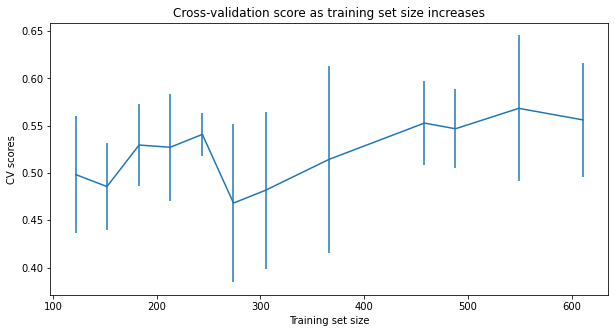

In [117]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');


## Conclusions
